In [ ]:
import tensorflow as tf
print(tf.version)

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.8/dist-packages/tensorflow/_api/v2/version/__init__.py'>


In [ ]:
floating = tf.Variable([[3.4,5.6],[4.5,6.7]],tf.float16)
print(floating)

<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[3.4, 5.6],
       [4.5, 6.7]], dtype=float32)>


In [ ]:
t = tf.ones([5,5,5,5])

t = tf.reshape(t, [5,125])
print(t)

tf.Tensor(
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

In [ ]:
!pip install -q sklearn

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

In [ ]:
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
print(dftrain.head())
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

   survived     sex   age  n_siblings_spouses  parch     fare  class     deck  \
0         0    male  22.0                   1      0   7.2500  Third  unknown   
1         1  female  38.0                   1      0  71.2833  First        C   
2         1  female  26.0                   0      0   7.9250  Third  unknown   
3         1  female  35.0                   1      0  53.1000  First        C   
4         0    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  


In [ ]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


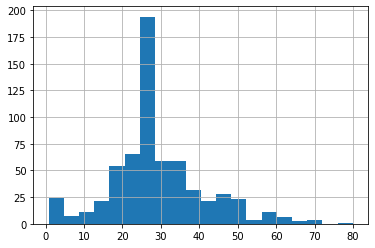

In [ ]:
dftrain.age.hist(bins=20)

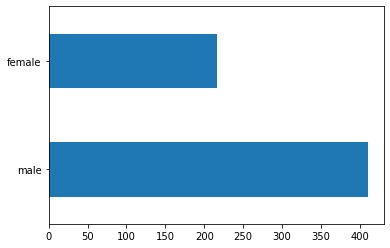

In [ ]:
dftrain.sex.value_counts().plot(kind='barh')

In [ ]:
CAREGORICAL_COLUMNS = ['sex', 'n_siblings_spouses','class', 'deck',
                       'embark_town','alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CAREGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name,vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

In [ ]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)

linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result['accuracy'])

0.77272725


In [ ]:
result = list(linear_est.predict(eval_input_fn))
print(dfeval.loc[2])
print(y_eval.loc[2])
print(result[2]['probabilities'][1])

sex                        female
age                          58.0
n_siblings_spouses              0
parch                           0
fare                        26.55
class                       First
deck                            C
embark_town           Southampton
alone                           y
Name: 2, dtype: object
1
0.47167885


In [ ]:
CSV_COLUMN_NAMES = ['SepalLength','SepalWidth',"PetalLength",'PetalWidth','Species']
SPECIES = ['Setosa','Versicolor', 'Virginica']

In [ ]:
train_path= tf.keras.utils.get_file(
    'iris_training.csv',"https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv")
test_path = tf.keras.utils.get_file(
    'iris_training.csv',"https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"
)

train = pd.read_csv(train_path, names=CSV_COLUMN_NAMES, header=0)
test = pd.read_csv(test_path,names=CSV_COLUMN_NAMES, header=0)

2194/2194 [==============================] - 0s 0us/step


In [ ]:
train.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
0,6.4,2.8,5.6,2.2,2
1,5.0,2.3,3.3,1.0,1
2,4.9,2.5,4.5,1.7,2
3,4.9,3.1,1.5,0.1,0
4,5.7,3.8,1.7,0.3,0


In [ ]:
train_y = train.pop('Species')
test_y =  test.pop('Species')
train.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth
0,6.4,2.8,5.6,2.2
1,5.0,2.3,3.3,1.0
2,4.9,2.5,4.5,1.7
3,4.9,3.1,1.5,0.1
4,5.7,3.8,1.7,0.3


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf

import pandas as pd

CSV_COLUMN_NAMES = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']
SPECIES = ['Setosa', 'Versicolor', 'Virginica']

train_path = tf.keras.utils.get_file(
    "iris_training.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv")
test_path = tf.keras.utils.get_file(
    "iris_test.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv")

train = pd.read_csv(train_path, names=CSV_COLUMN_NAMES, header=0)
test = pd.read_csv(test_path, names=CSV_COLUMN_NAMES, header=0)

573/573 [==============================] - 0s 0us/step


In [ ]:
train_y = train.pop('Species')
test_y = test.pop('Species')

def input_fn(features, labels, training=True, batch_size=256):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # Shuffle and repeat if you are in training mode.
    if training:
        dataset = dataset.shuffle(1000).repeat()

    return dataset.batch(batch_size)

my_feature_columns = []
for key in train.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))

classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    hidden_units=[30, 10],
    n_classes=3)

classifier.train(
    input_fn=lambda: input_fn(train, train_y, training=True),
    steps=5000)



In [ ]:
eval_result = classifier.evaluate(
    input_fn=lambda: input_fn(test, test_y, training=False))

print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))


Test set accuracy: 0.800



In [ ]:
def input_fn(features, batch_size=256):
    # Convert the inputs to a Dataset without labels.
    return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)

features = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth']
predict = {}

print("Please type numeric values as prompted.")
for feature in features:
  valid = True
  while valid:
    val = input(feature + ": ")
    if not val.isdigit(): valid = False

  predict[feature] = [float(val)]

predictions = classifier.predict(input_fn=lambda: input_fn(predict))
for pred_dict in predictions:
    class_id = pred_dict['class_ids'][0]
    probability = pred_dict['probabilities'][class_id]

    print('Prediction is "{}" ({:.1f}%)'.format(
        SPECIES[class_id], 100 * probability))

Please type numeric values as prompted.


KeyboardInterrupt: ignored

In [ ]:
import tensorflow_probability as tfp

In [ ]:
tfd = tfp.distributions  # making a shortcut for later on
initial_distribution = tfd.Categorical(probs=[0.2, 0.8])  # Refer to point 2 above
transition_distribution = tfd.Categorical(probs=[[0.5, 0.5],
                                                 [0.2, 0.8]])  # refer to points 3 and 4 above
observation_distribution = tfd.Normal(loc=[0., 15.], scale=[5., 10.])  # refer to point 5 above

# the loc argument represents the mean and the scale is the standard devit

In [ ]:
model = tfd.HiddenMarkovModel(
    initial_distribution=initial_distribution,
    transition_distribution=transition_distribution,
    observation_distribution=observation_distribution,
    num_steps=7)

In [ ]:
mean = model.mean()

with tf.compat.v1.Session() as sess:
  print(mean.numpy())

# neural net

In [ ]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()


In [ ]:
train_images.shape

In [ ]:
train_images[0,23,23]

In [ ]:
train_labels[:10]

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [ ]:
plt.figure()
plt.imshow(train_images[301])
plt.colorbar()
plt.grid(False)
plt.show()

In [ ]:
%tensorflow_version 2.x  # this line is not required unless you are in a notebook
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
fashion_mnist = keras.datasets.fashion_mnist  # load dataset

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [ ]:
train_images = train_images / 255.0

test_images = test_images / 255.0

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),  # input layer (1)
    keras.layers.Dense(128, activation='relu'),  # hidden layer (2)
    keras.layers.Dense(10, activation='softmax') # output layer (3)
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(train_images, train_labels, epochs=1)

In [ ]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=1)

print('Test accuracy:', round(test_acc,5))

In [ ]:
predictions = model.predict(test_images)
print(class_names[np.argmax(predictions[30])])
plt.figure()
plt.imshow(test_images[30])
plt.colorbar()
plt.grid(False)
plt.show()

In [ ]:
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR

def predict(model, image, correct_label):
  class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
  prediction = model.predict(np.array([image]))
  predicted_class = class_names[np.argmax(prediction)]

  show_image(image, class_names[correct_label], predicted_class)


def show_image(img, label, guess):
  plt.figure()
  plt.imshow(img, cmap=plt.cm.binary)
  plt.title("Excpected: " + label)
  plt.xlabel("Guess: " + guess)
  plt.colorbar()
  plt.grid(False)
  plt.show()


def get_number():
  while True:
    num = input("Pick a number: ")
    if num.isdigit():
      num = int(num)
      if 0 <= num <= 1000:
        return int(num)
    else:
      print("Try again...")

num = get_number()
image = test_images[num]
label = test_labels[num]
predict(model, image, label)

#Computer vision

In [ ]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

170498071/170498071 [==============================] - 3s 0us/step


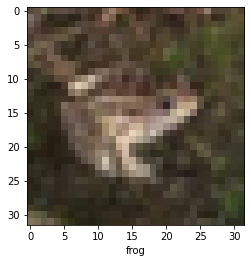

In [ ]:
IMG_INDEX = 22  # change this to look at other images

plt.imshow(train_images[IMG_INDEX] ,cmap=plt.cm.binary)
plt.xlabel(class_names[train_labels[IMG_INDEX][0]])
plt.show()

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
Total params: 56,320
Trainable params: 56,320
Non-traina

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=4,
                    validation_data=(test_images, test_labels))

Epoch 1/4
1563/1563 [==============================] - 88s 56ms/step - loss: 1.5550 - accuracy: 0.4299 - val_loss: 1.2708 - val_accuracy: 0.5395
Epoch 2/4
1563/1563 [==============================] - 92s 59ms/step - loss: 1.1758 - accuracy: 0.5828 - val_loss: 1.0828 - val_accuracy: 0.6180
Epoch 3/4
1563/1563 [==============================] - 84s 54ms/step - loss: 1.0198 - accuracy: 0.6392 - val_loss: 1.0230 - val_accuracy: 0.6356
Epoch 4/4
 310/1563 [====>.........................] - ETA: 1:03 - loss: 0.9312 - accuracy: 0.6708

In [ ]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print(test_acc)